In [106]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
%matplotlib inline

Feature (Autocorrelation) Clustering

Second used clustering approach is Feature-based clustering. Instead of comparing raw time series feature-based clustering suggests retrieving a certain metric from these time series, such as mean, covariance, autocorrelation, quantile auto covariance etc., and do clustering on the obtained values of the selected metric.
Since in the current study we are interested in separating stations that have seasonal fluctuations and trends, the autocorrelation metric was chosen as a feature. Autocorrelation works like a simple Pearson correlation, but comparing the time series with its own time-shifted version.
Therefore, it helps to reveal whether past time series values can influence (or predict) subsequent values.
The time series shifted in time differs from the original one by the amount of the shift, which is also called the lag.
In case of  absence any patterns in the data (random time series) the autocorrelation function declines to near zero rapidly.
When trends are present in a time series, shorter lags typically have large positive correlations because observations closer in time tend to have similar values. The correlations taper off slowly as the lags increase.
When seasonal patterns are present, the autocorrelations are larger for lags at multiples of the seasonal frequency than for other lags.

In [323]:
# helper functions
def acf(x, n_lags):
    return sm.tsa.stattools.acf(x, nlags=n_lags)

def plot_timeseries(data, time, ts_index):
    fig, ax = plt.subplots()
    ax.plot(time, data[ts_index,:])
    for xc in time:
        ax.axvline(x=xc, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
    i = 0
    for xy in time:
        if i % 4 == 0:
            ax.axvline(x=xy, color='red', linewidth=0.5, linestyle='-', alpha=0.5)
        i = i + 1
    ax.set_title(f"Time Series  {ts_index}")
    plt.show()

def plot_cluster(model, acf_arr, n_lags, cluster_index):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, n_lags))
    ts = []
    nsignals = len(acf_arr)

    # j ranges over the series ACFs
    for j in range(nsignals):

        # Plot ACF j in the current cluster i
        if model.labels_[j] == cluster_index:
            ts.append(j)
            plt.plot(acf_arr[j, :])

    plt.ylabel('Correlation')
    plt.xlabel('Lag')
    plt.title(f"Autocorrelation plot\nCluster {cluster_index}\nTime series {ts}")
    plt.show()

def replace_outliers(data):
    nsignals = len(data)
    transformed_data = deepcopy(data)

    smoother = LowessSmoother(smooth_fraction=0.1, iterations=5)
    smoother.smooth(data)

    # generate intervals
    low, up = smoother.get_intervals('prediction_interval')

    points = smoother.data
    up_points = up
    low_points = low

    for i in range(nsignals):

        for j in range(len(points[i, :])-1, -1, -1):
            current_point = points[i,j]
            current_up = up_points[i,j]
            current_low = low_points[i,j]
            if current_point > current_up:
                transformed_data[i,j] = current_up
            if current_point < current_low:
               transformed_data[i,j] = current_low

    return transformed_data

def perform_acf_clustering(n_clusters, n_lags, data):
    lag_arr = np.repeat(n_lags, data.shape[0])
    acf_list = list(map(acf, data, lag_arr))
    acf_arr = np.array(acf_list)

    #plt.figure(figsize=(12, 3))
    #plt.xlim((1, n_lags))
    #for n in range(nsignals):
    #    plt.plot(range(n_lags+1), acf_arr[n,:])
    #plt.show()

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(acf_arr)

    return acf_arr, kmeans


In [324]:
df = pd.read_csv(f'C:/Users/YC/PycharmProjects/nitrateAnalysis/intermediate_data/stations_for_clustering30.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [325]:
# transform df to numpy array
stations = df['Objektnummer'].unique()
ndarray_cols = int(len(stations))
ndarray_rows = int(len(df.index)/len(stations))
data = df['LinearInter'].values.reshape(ndarray_cols,ndarray_rows)
time = df['Date'].unique()
nsignals = len(data)

Detecting and smoothing outliers, since the outliers can significantly distort the pattern of interest

In [326]:
# detect and replace outliers
transformed_data = replace_outliers(data)

Performing clustering

In [341]:
acf_arr, kmeans = perform_acf_clustering(4, 70, transformed_data)

Plotting autocorrelation plots of obtained clusters

Current cluster contains only one time series, and this time series has a significant seasonal variation. Due to the high autocorrelation for the lags representing the annual frequency, it can be seen that the values of the last year's season affect the same season but the value of the next year.

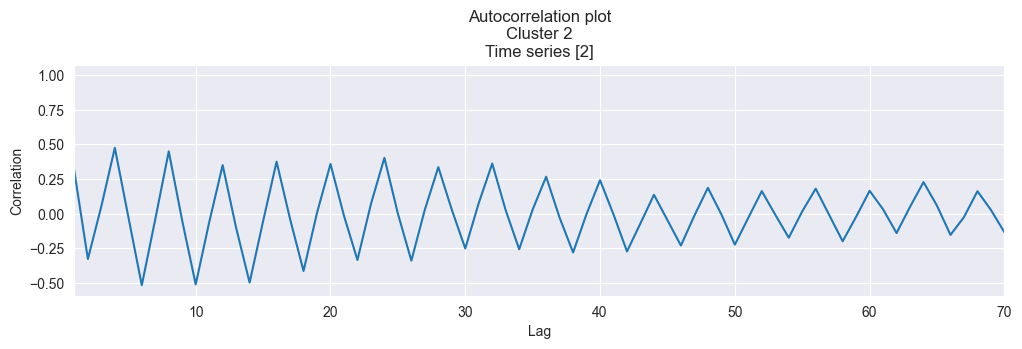

In [342]:
plot_cluster(kmeans, acf_arr, 70, 2)

Plotting one original time series from the cluster for example

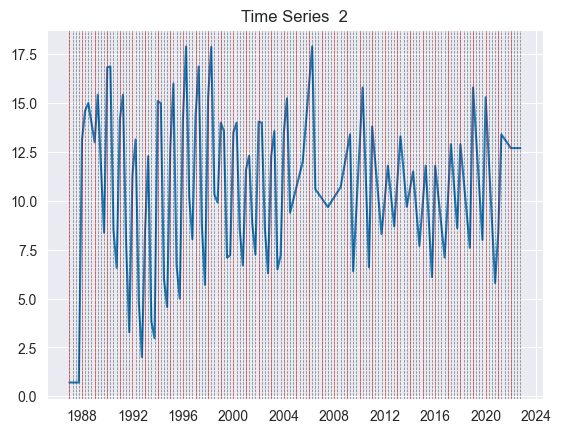

In [329]:
plot_timeseries(transformed_data, time, 2)

Time series of the next cluster have a very high autocorrelation values for the first leg, then it drops sharply, and different frequency fluctuations begin. These fluctuations in the most cases exceed the annual range and are not of fixed period. These fluctuations can be called cycles, they usually occur due to a certain event that affects the measured indicator. They can also be part of some long-term non-linear trend that is not observed in the considered time range.

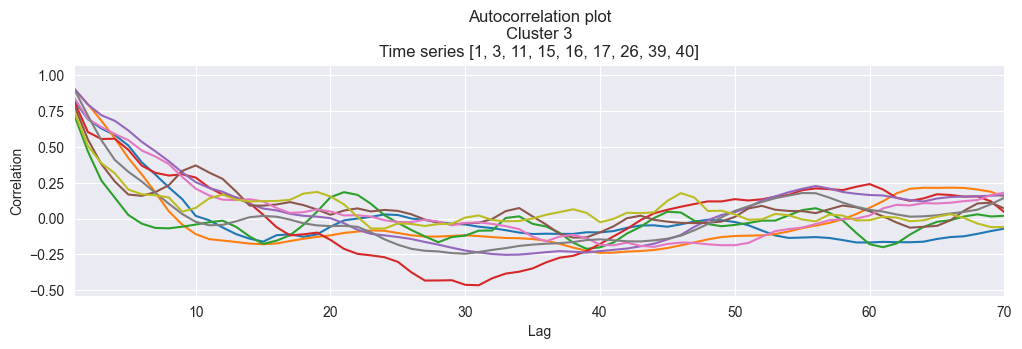

In [344]:
plot_cluster(kmeans, acf_arr, 70, 3)

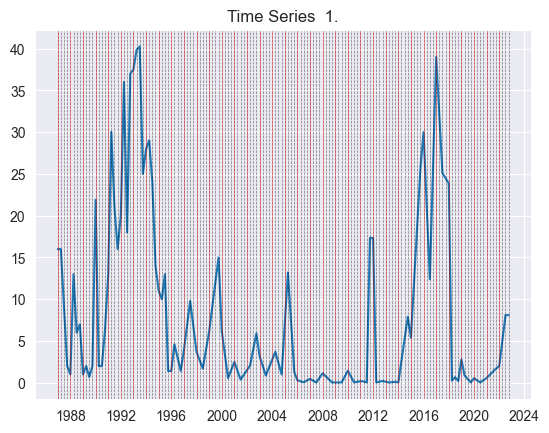

In [317]:
plot_timeseries(transformed_data, time, 1)

The time series in the next cluster is similar to the previous one, but in this case, the autocorrelation falls more smoothly, which indicates that besides cycles a trend is also presented.

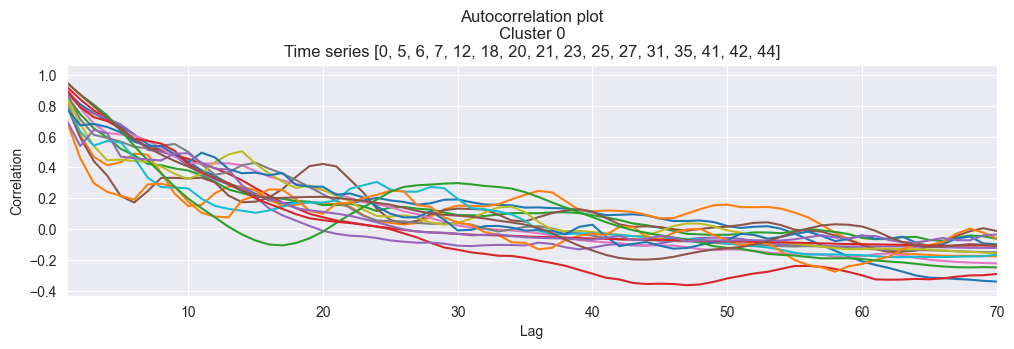

In [345]:
plot_cluster(kmeans, acf_arr, 70, 0)

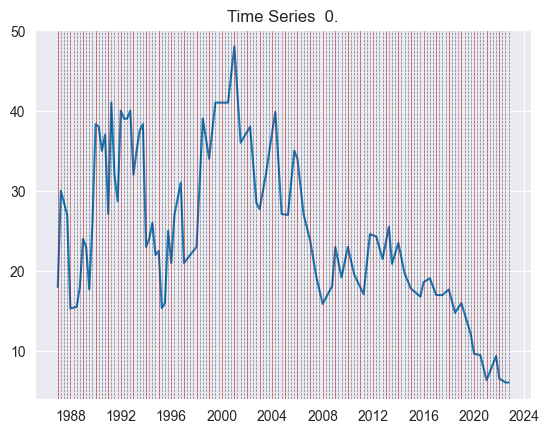

In [319]:
plot_timeseries(transformed_data, time, 0)

The last cluster has consolidated time series, mostly with a more pronounced trend and less cyclical behavior.

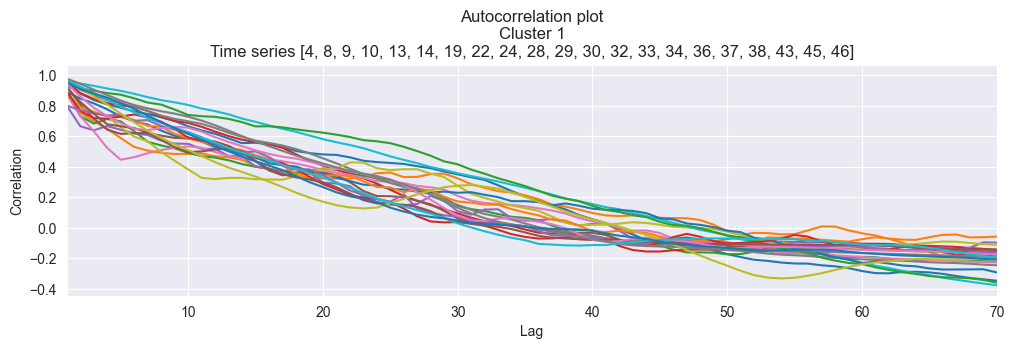

In [346]:
plot_cluster(kmeans, acf_arr, 70, 1)

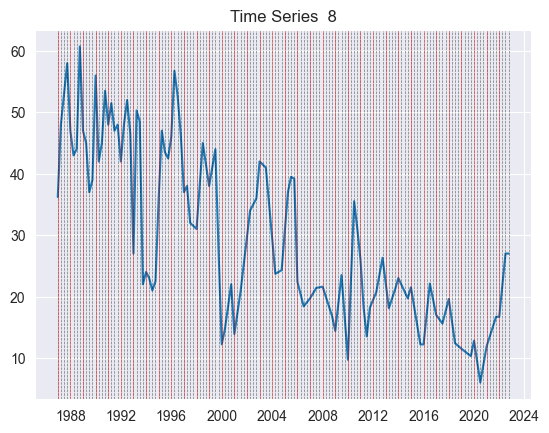

In [348]:
plot_timeseries(transformed_data, time, 8)

References: https://medium.com/wwblog/time-series-clustering-based-on-autocorrelation-using-python-94d5e3475179
https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/